**<h1 align="center">Data Analysis Notebook</h1>**

<p align="center"><i>Analyze any CSV dataset using Python</i></p>

## Global variables

### Global variables

In [1]:
CSV_FOLDER = ""
CSV_FILE = "insurance_raw.csv"
CSV_SEPARATOR = ","  # Specify the CSV separator, e.g., ',' or '\t'
IMPORT_COLUMNS = []  # If empty, import all columns
CHUNK_SIZE = 20000  # Number of rows per chunk

TARGET_COLUMN = "expenses"

# ANSI escape codes for colored output
GREEN = "\033[92m"
BLUE = "\033[94m"
YELLOW = "\033[93m"
RESET = "\033[0m"  # White

### Python Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

## Import CSV to dataframe

### CSV import

In [3]:
print(f"\n{YELLOW}Importing data from CSV...{RESET}")

CSV_FILE_PATH = CSV_FOLDER + CSV_FILE

def import_data():
    # Initialize an empty DataFrame
    data_df = pd.DataFrame()

    # Read CSV in chunks
    for chunk in pd.read_csv(
        CSV_FILE_PATH,
        chunksize=CHUNK_SIZE,
        sep=CSV_SEPARATOR,
        usecols=IMPORT_COLUMNS or None,
        header=0,
        on_bad_lines="skip",
        low_memory=False
    ):
        data_df = pd.concat([data_df, chunk], ignore_index=True)
        
    return data_df
    
data_df = import_data()


Importing data from CSV...


### Column detection

In [4]:
def detect_column_types(data_df):
    """
    Detects column types in a DataFrame and returns lists of column names by type.

    Parameters:
        data_df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        tuple: A tuple containing four lists:
            - numerical_columns: List of numerical column names.
            - categorical_columns: List of categorical column names.
            - datetime_columns: List of datetime column names.
            - bool_columns: List of boolean column names.
    """
    # Detect numerical columns
    numerical_columns = data_df.select_dtypes(include=['number']).columns.tolist()

    # Detect categorical columns
    categorical_columns = data_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Detect datetime columns
    datetime_columns = data_df.select_dtypes(include=['datetime']).columns.tolist()

    # Detect boolean columns
    bool_columns = data_df.select_dtypes(include=['bool']).columns.tolist()

    return numerical_columns, categorical_columns, datetime_columns, bool_columns

print(f"\n{YELLOW}Detecting column types...{RESET}")

numerical_columns, categorical_columns, datetime_columns, bool_columns = detect_column_types(data_df)


Detecting column types...


## Initial Data Exploration

### Functions

#### Distribution Graphs

In [5]:
# Afficher les distributions des variables numériques
def display_numerical_distribution(df, numerical_columns, grid_width=3, color="blue"):
    """
    Display the distribution of numerical columns in the dataframe in a grid layout.
    
    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - numerical_columns (list): List of numerical columns to plot.
    - grid_width (int): Maximum number of plots per row in the grid.
    - color (str): Color of the histogram bars.

    Returns:
    - None: Displays the plots directly.
    """
    num_columns = len(numerical_columns)
    num_rows = math.ceil(num_columns / grid_width)

    fig, axes = plt.subplots(num_rows, grid_width, figsize=(grid_width * 6, num_rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        sns.histplot(
            df[column].dropna(), 
            bins=30, 
            kde=True, 
            color=color, 
            ax=axes[i]
        )
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Afficher les distributions des variables catégorielles
def display_categorical_distribution(df, categorical_columns, grid_width=3, color="blue"):
    """
    Display the distribution of categorical columns in the dataframe in a grid layout.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - categorical_columns (list): List of categorical columns to plot.
    - grid_width (int): Maximum number of plots per row in the grid.
    - color (str): Color of the bars.

    Returns:
    - None: Displays the plots directly.
    """
    num_columns = len(categorical_columns)
    num_rows = math.ceil(num_columns / grid_width)

    fig, axes = plt.subplots(num_rows, grid_width, figsize=(grid_width * 6, num_rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, column in enumerate(categorical_columns):
        # Prepare data for plotting
        category_counts = df[column].value_counts(dropna=False)
        sns.barplot(
            x=category_counts.index,
            y=category_counts.values,
            ax=axes[i],
            color=color
        )
        axes[i].set_title(f'Count of {column} Categories')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

#### Missing Value Heatmap

In [6]:
def plot_missing_values(dataframe):
    plt.figure(figsize=(16, 10))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

#### Outliers Graphs

In [7]:
def display_outliers(dataframe, selected_columns, grid_width=3, color="blue"):
    """
    Displays boxplots for the selected columns to visualize potential outliers in a grid layout.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - selected_columns (list): List of columns to display outliers.
    - grid_width (int): Maximum number of plots per row in the grid.
    - color (str): Color for the boxplots.

    Returns:
    - None: Displays the graphs directly.
    """
    numeric_columns = [col for col in selected_columns if pd.api.types.is_numeric_dtype(dataframe[col])]
    num_columns = len(numeric_columns)
    num_rows = math.ceil(num_columns / grid_width)

    fig, axes = plt.subplots(num_rows, grid_width, figsize=(grid_width * 6, num_rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, column in enumerate(numeric_columns):
        sns.boxplot(ax=axes[i], x=dataframe[column], color=color)
        axes[i].set_title(f'{column}')
        axes[i].set_ylabel(column)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def display_outliers_violin(dataframe, selected_columns, grid_width=3, color="blue"):
    """
    Displays horizontal violin plots for the selected columns to visualize potential outliers in a grid layout.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - selected_columns (list): List of columns to display outliers.
    - grid_width (int): Maximum number of plots per row in the grid.
    - color (str): Color for the violin plots.

    Returns:
    - None: Displays the graphs directly.
    """
    numeric_columns = [col for col in selected_columns if pd.api.types.is_numeric_dtype(dataframe[col])]
    num_columns = len(numeric_columns)
    num_rows = math.ceil(num_columns / grid_width)

    fig, axes = plt.subplots(num_rows, grid_width, figsize=(grid_width * 6, num_rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, column in enumerate(numeric_columns):
        sns.violinplot(data=dataframe, x=column, color=color, ax=axes[i])
        axes[i].set_title(f"{column}")
        axes[i].set_xlabel(column)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Dataframe Statistics

#### Shape

In [8]:
data_df.shape

(1338, 7)

#### Column Types

In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Missing data

In [10]:
data_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

### Distribution Graphs

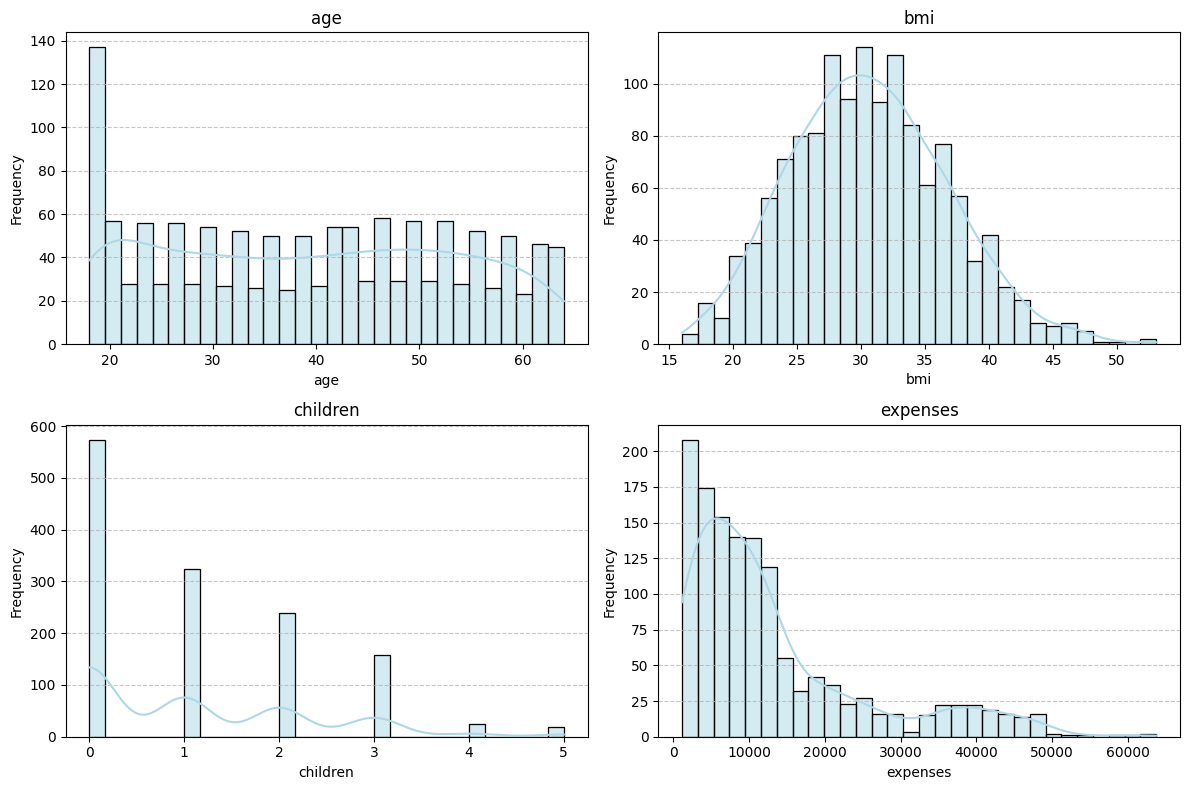

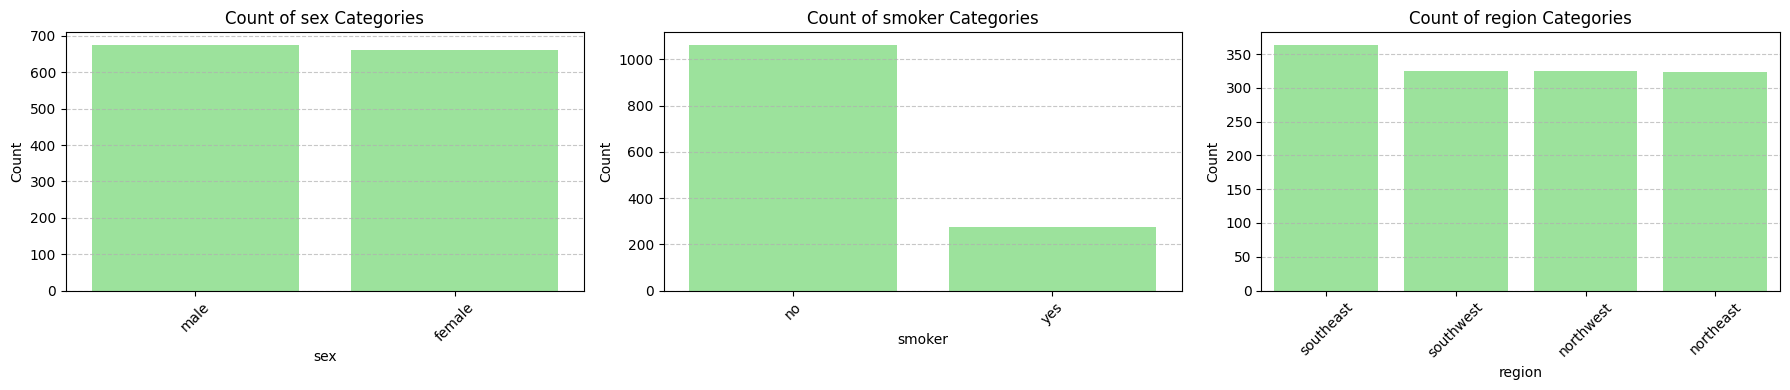

In [11]:
# Visualisation des colonnes numériques
selected_columns = numerical_columns
display_numerical_distribution(data_df, selected_columns, grid_width=2, color="lightblue")

selected_columns = categorical_columns
# Visualisation des variables catégoriques
display_categorical_distribution(data_df, selected_columns, grid_width=3, color="lightgreen")

### Missing Value Heatmap

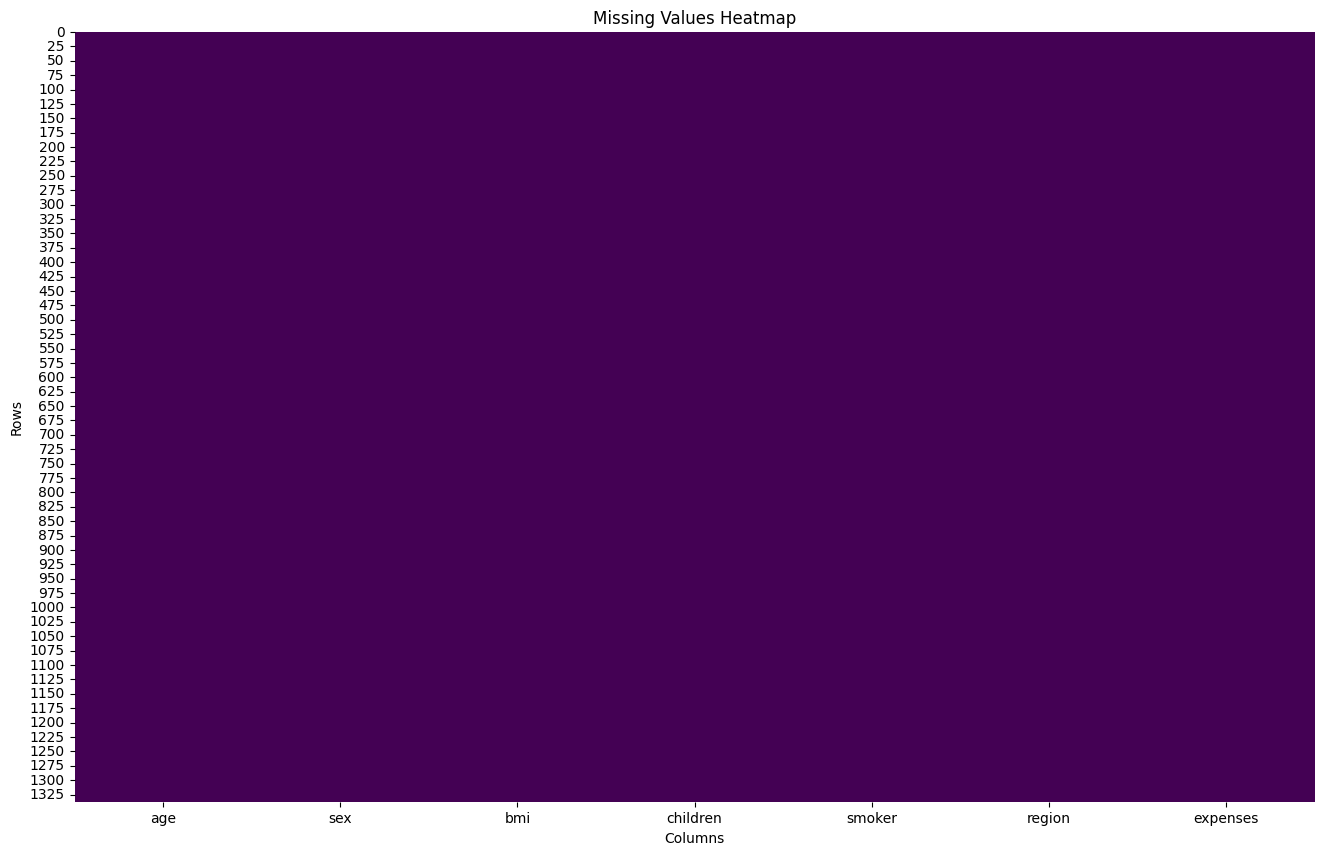

In [12]:
plot_missing_values(data_df)

### Outliers Graphs

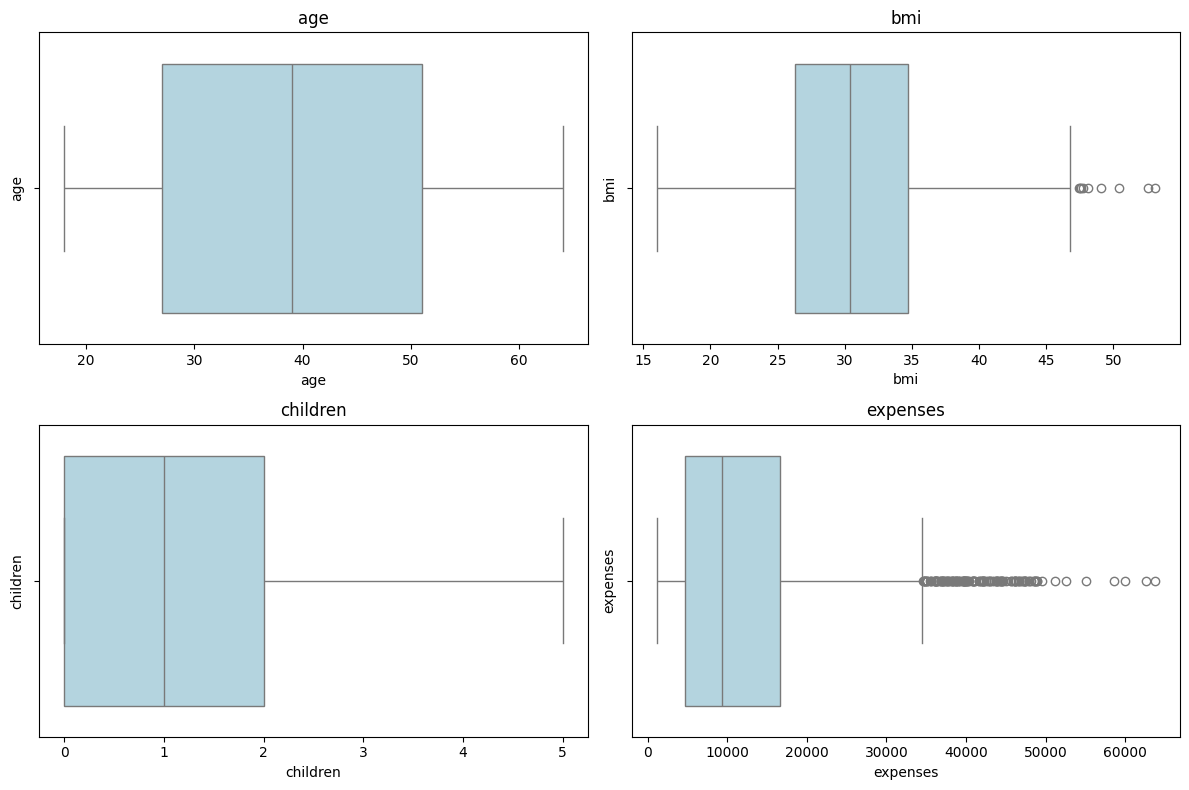

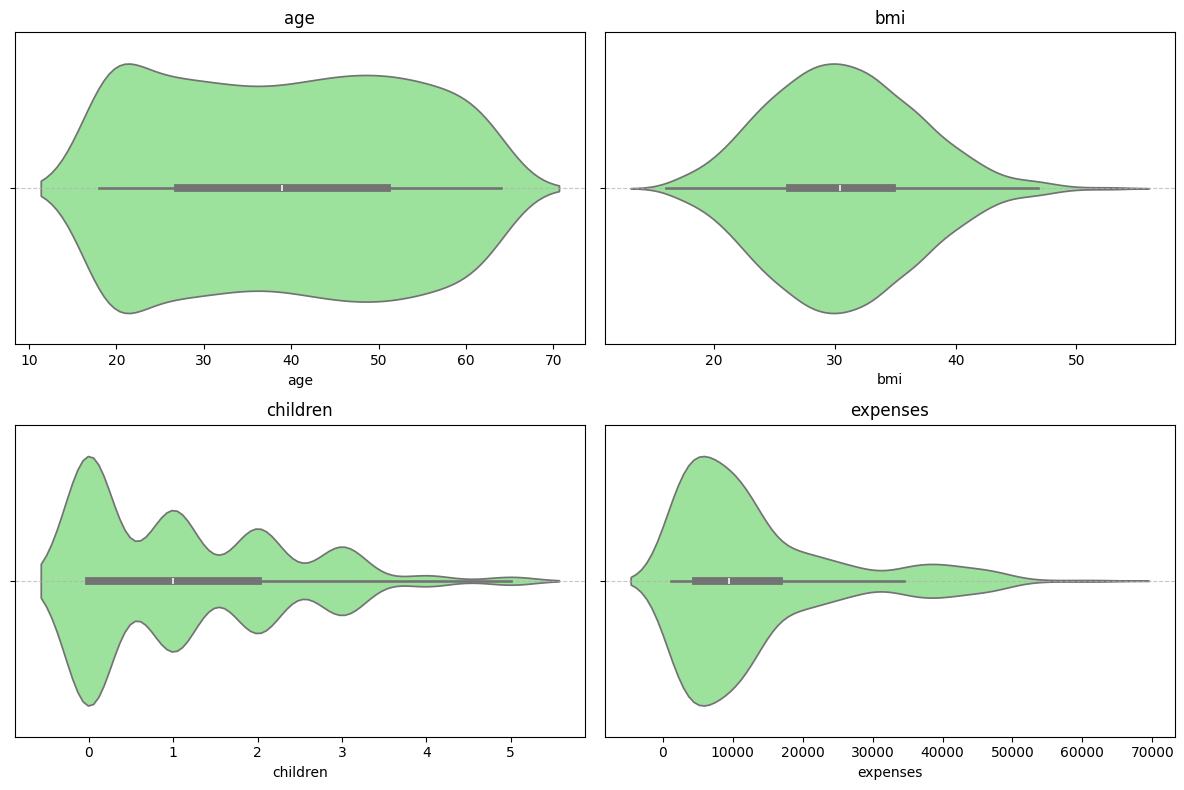

In [13]:
# Visualize outliers
display_outliers(data_df, numerical_columns, grid_width=2, color="lightblue")
display_outliers_violin(data_df, numerical_columns, grid_width=2, color="lightgreen")

## Encoding

### Functions

In [14]:
def encode_categorical_columns(dataframe):
    """
    Encodes categorical columns based on predefined rules.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the categorical columns.

    Returns:
    - pd.DataFrame: The dataframe with encoded categorical columns.
    """
    # Ensure we are working on a copy to avoid modifying the original dataframe
    dataframe = dataframe.copy()

    # Encode 'sex' (0: female, 1: male)
    dataframe['sex'] = dataframe['sex'].map({'female': 0, 'male': 1}).fillna(-1).astype(int)

    # Encode 'smoker' (0: No, 1: Yes)
    dataframe['smoker'] = dataframe['smoker'].map({'no': 0, 'yes': 1}).fillna(-1).astype(int)

    # One-Hot Encode 'region'
    dataframe = pd.get_dummies(dataframe, columns=['region'], drop_first=False)
    
    # Convert all one-hot encoded columns to int
    region_columns = [col for col in dataframe.columns if col.startswith('region_')]
    dataframe[region_columns] = dataframe[region_columns].astype(int)

    return dataframe

### Encoding

In [15]:
# Encode categorical columns
encode = True

if encode:
    print(f"\n{YELLOW}Encoding categorical columns...{RESET}")
    encoded_df = encode_categorical_columns(data_df)
else:
    encoded_df = data_df


Encoding categorical columns...


## Extensive Data Exploration

### Functions

#### Correlation Matrix

In [16]:
def display_correlation_matrix(dataframe):
    """
    Displays a heatmap of the correlation matrix for all numeric columns in the dataframe.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data.

    Returns:
    - None: Displays the heatmap directly.
    """
    # Select only numeric columns
    numeric_dataframe = dataframe.select_dtypes(include=['number'])

    if numeric_dataframe.empty:
        print("No numeric columns found in the dataframe.")
        return

    # Calculate and display the correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = numeric_dataframe.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='vlag', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

#### Correlation to Target Variable

In [17]:
def target_correlation_matrix(dataframe, target_column):
    # Sélection des colonnes numériques
    numeric_cols = dataframe.select_dtypes(include=[np.number])

    # Calcul de la matrice de correlation
    correlation_matrix = numeric_cols.corr()

    # Correlation avec la cible
    correlation_with_target = correlation_matrix[target_column].sort_values(ascending=False)

    # Affichage
    plt.figure(figsize=(6, len(correlation_with_target) * 0.5))
    sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='vlag', fmt=".2f", cbar=True)
    plt.title(f'Correlation Heatmap to target: {target_column}')
    plt.show()

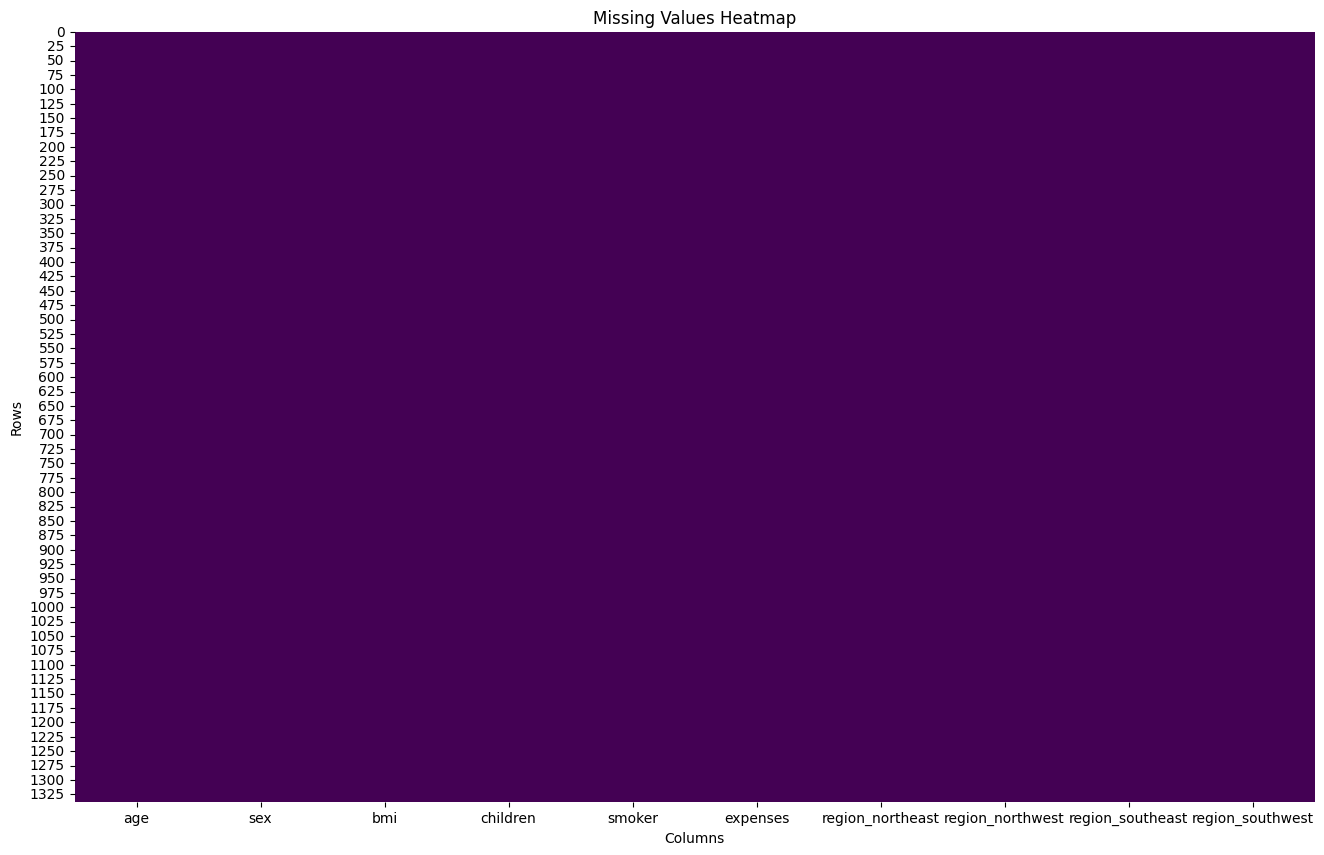

In [18]:
plot_missing_values(encoded_df)

### Correlation Matrix

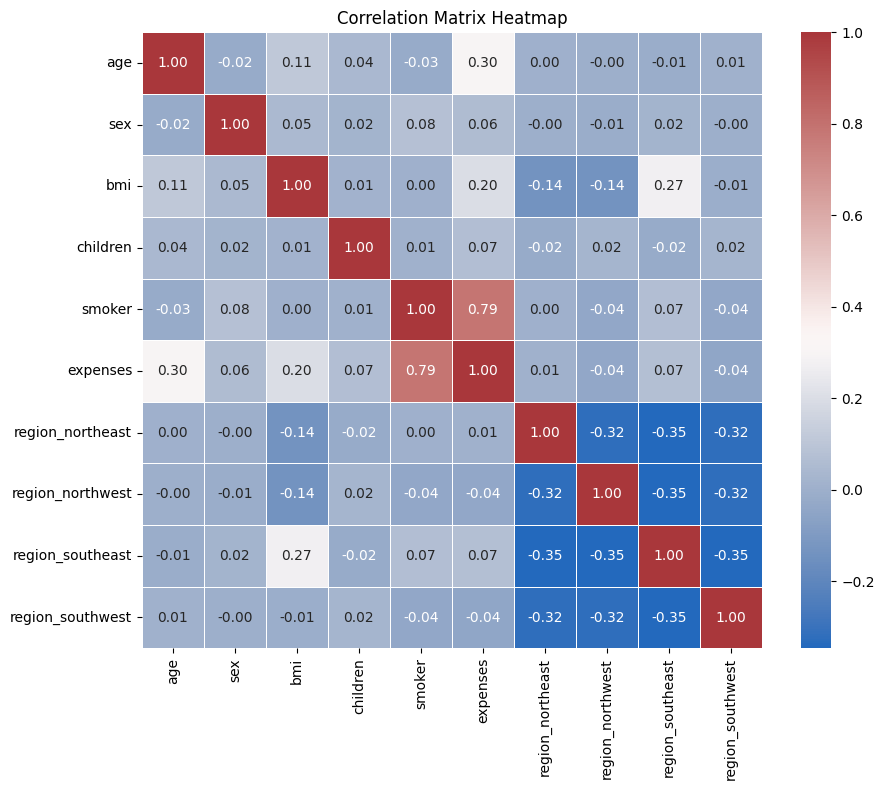

In [19]:
# Display correlation matrix heatmap
display_correlation_matrix(encoded_df)

### Correlation to Target Variable

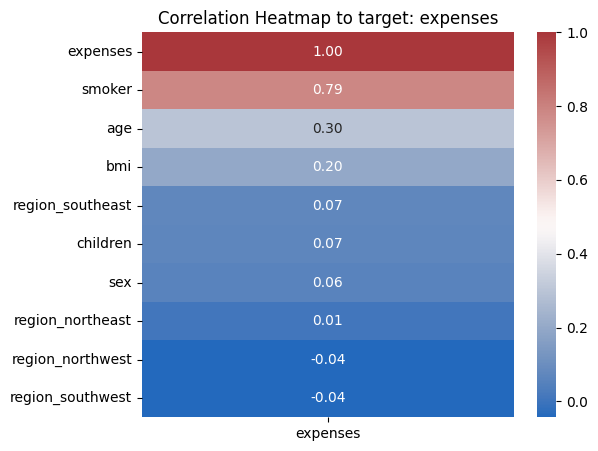

In [20]:
target_correlation_matrix(encoded_df, TARGET_COLUMN)